In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, pprint, h5py, emoji
import numpy as np
from glob import glob
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from scipy.optimize import minimize

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal

%matplotlib inline
%config InlineBackend.figure_format='retina'

Could not import BEM module. Please do so manually.


In [2]:
box_length=20E-6
inserted_res_length = 80

xeval = np.linspace(-4.0, box_length*1E6, 751)
yeval = anneal.construct_symmetric_y(-4.0, 151)

dx = np.diff(xeval)[0]*1E-6
dy = np.diff(yeval)[0]*1E-6

master_path = r"/Users/gkoolstra/Desktop/Single electron loading/M018V4"
#r"/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V4"

x_eval, y_eval, output = anneal.load_data(master_path, xeval=xeval, yeval=yeval, mirror_y=True,
                                          extend_resonator=False, insert_resonator=True, do_plot=False,
                                          inserted_res_length=inserted_res_length, smoothen_xy=(0.25E-6, dy))

Resonator data was inserted from x = 7.87 um to x = 87.84 um


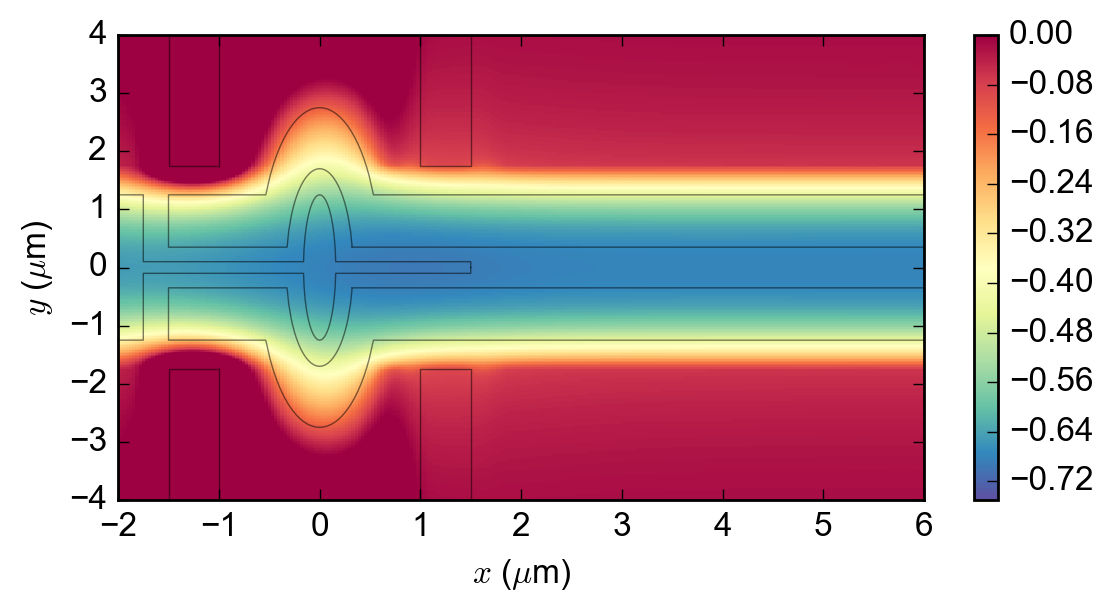

In [3]:
coefficients = [1.00, 0.95, 0, -1.00]

for i, c in enumerate(coefficients):
    if i == 0:
        potential_data = output[i]['V'] * c
    else: 
        potential_data += output[i]['V'] * c 

PP = anneal.PostProcess(save_path=None)

# Plot the resonator and trap electron configuration
fig2 = plt.figure(figsize=(6.5, 3))
common.configure_axes(12)
plt.pcolormesh(x_eval[0,:] * 1E6, y_eval[:,0] * 1E6, -potential_data.T, cmap=plt.cm.Spectral_r, vmax=0.0, vmin=-0.75)
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
#plt.xlim(np.min(x_eval)*1E6, 10)
#plt.ylim(np.min(y_eval)*1E6, np.max(y_eval)*1E6)
PP.draw_from_dxf(r"/Users/gkoolstra/Desktop/Single electron loading/M018V4/all_electrodes.dxf", 
                 color='black', alpha=0.5, lw=0.5)

plt.xlim(-2,6)
plt.ylim(-4,4)

plt.colorbar()
plt.show()

#common.save_figure(fig2, save_path=r"/Users/gkoolstra/Google Drive/grad school/schuster lab/Presentations/March Meeting 2017")

In [4]:
CMS = anneal.TrapAreaSolver(x_eval[0,:], y_eval[:,0], -potential_data,
                            spline_order_x=3, spline_order_y=3, smoothing=0.00,
                            include_screening=True, screening_length=2*0.75E-6)

In [ ]:
X_eval, Y_eval = np.meshgrid(x_eval[0,:], y_eval[:,0])

In [6]:
# Solve for the electron positions in the trap area!
ConvMon = anneal.ConvergenceMonitor(Uopt=CMS.Vtotal, grad_Uopt=CMS.grad_total, N=10,
                                    Uext=CMS.V, xext=np.arange(-2E-6, 6E-6, dx), yext=y_eval[:,0], verbose=True, eps=1E-10,
                                    figsize=(6.5, 3.0), clim=(-0.75, 0),
                                    save_path=r"/Users/gkoolstra/Desktop/Single electron loading/Anneal example")

ConvMon.figsize = (6.5, 3.0)
ConvMon.electrode_outline_filename = r"/Users/gkoolstra/Desktop/Single electron loading/M018V4/all_electrodes.dxf"

N_electrons = 160
N_rows = N_electrons
row_spacing = 0.10E-6
N_cols = 1
col_spacing = 0.10E-6

electron_initial_positions = anneal.get_rectangular_initial_condition(N_electrons, N_rows=N_rows, N_cols=N_cols,
                                                                      x0=(inserted_res_length*1E-6 + box_length)/2., 
                                                                      y0=0.0E-6, dx=0.20E-6)

trap_minimizer_options = {'jac': CMS.grad_total,
                          'options': {'disp': False, 'gtol': 1E2, 'eps': 1E-10},
                          'callback': ConvMon.save_pictures}

res = minimize(CMS.Vtotal, electron_initial_positions, method='CG', **trap_minimizer_options)

print(ConvMon.figsize)
print(res['message'])

0	Uopt: -106.71126173 eV	Norm of gradient: 1.62e+04 eV/m
10	Uopt: -107.05651392 eV	Norm of gradient: 5.59e+04 eV/m
20	Uopt: -107.26485510 eV	Norm of gradient: 1.26e+04 eV/m
30	Uopt: -107.32362387 eV	Norm of gradient: 9.47e+03 eV/m
40	Uopt: -107.43744937 eV	Norm of gradient: 1.77e+04 eV/m
50	Uopt: -107.54535696 eV	Norm of gradient: 1.68e+04 eV/m
60	Uopt: -107.62218743 eV	Norm of gradient: 8.53e+03 eV/m
70	Uopt: -107.69816986 eV	Norm of gradient: 1.51e+04 eV/m
80	Uopt: -107.80546542 eV	Norm of gradient: 4.28e+03 eV/m
90	Uopt: -107.88904881 eV	Norm of gradient: 1.19e+04 eV/m
100	Uopt: -107.94830922 eV	Norm of gradient: 8.25e+03 eV/m
110	Uopt: -107.97151046 eV	Norm of gradient: 3.57e+03 eV/m
120	Uopt: -107.99869477 eV	Norm of gradient: 3.68e+03 eV/m
130	Uopt: -108.04740360 eV	Norm of gradient: 4.46e+03 eV/m
140	Uopt: -108.07122304 eV	Norm of gradient: 2.03e+03 eV/m
150	Uopt: -108.16554305 eV	Norm of gradient: 1.13e+04 eV/m
160	Uopt: -108.17911116 eV	Norm of gradient: 6.23e+03 eV/m
170	Uopt

TypeError: First argument must be a path or file object reading bytes

TypeError: First argument must be a path or file object reading bytes

In [ ]:
PP = anneal.PostProcess(save_path=None)

# Plot the resonator and trap electron configuration
fig2 = plt.figure(figsize=(6.5, 3))
common.configure_axes(12)
plt.pcolormesh(x_eval[0,:] * 1E6, y_eval[:,0] * 1E6, -potential_data.T, cmap=plt.cm.RdYlBu, vmax=0.0, vmin=-0.75)
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.plot(res['x'][::2] * 1E6, res['x'][1::2] * 1E6 , 'o', color="mediumpurple")
#plt.xlim(np.min(x_eval)*1E6, 10)
#plt.ylim(np.min(y_eval)*1E6, np.max(y_eval)*1E6)
PP.draw_from_dxf(r"/Users/gkoolstra/Desktop/Single electron loading/M018V4/all_electrodes.dxf", 
                 color='black', alpha=0.5, lw=0.5)

plt.xlim(-2,6)
plt.ylim(-4,4)

plt.colorbar()
plt.show()

#common.save_figure(fig2, save_path=r"/Users/gkoolstra/Google Drive/grad school/schuster lab/Presentations/March Meeting 2017")